# Graph coloring heuristric for crew rostering

Research conducted by Baskin Leo

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import math
import itertools
from tqdm import tqdm
from copy import deepcopy
import seaborn as sns
import matplotlib.pyplot as plt

from tools import build_graph, coloring_algorithm, count_dict, get_cost, swap, find_best_color, tabu_search

sns.set_style("white", {'ytick.left': True, 'axes.spines.right': False, 'axes.spines.top':False})
plt.rcParams.update({'font.size': 22, 'figure.figsize': (18,12)})
np.random.seed(42)

## Task

**Consider the transportaion network of Moscow center. Estimate required number of workers and assign them for the scheduled shifts**

Research is based on a paper: https://www.researchgate.net/publication/343853034_Graph_Coloring_based_Heuristic_for_Crew_Rostering

![alt text](tr_map.png "Title")

## Data preparation

**First of all, let's look up for all routes that have at least 1 stop inside garden circle.** (Data collected by myself at https://wikiroutes.info/msk/catalog)

In [2]:
routes_df = pd.read_excel('routes_plan.xlsx')
routes_df.head(3)

,route,interval,from,to,length_km
0,m1,10,8,12,24.0
1,m2,12,12,16,21.0
2,m3,10,10,14,20.0


**In order to estimate number of shifts, we need to estimate number of buses per route. We will estimate average speed of the bus is 17 km/h.**

In [3]:
avg_speed = 17
shift_len = 4

In [4]:
routes_df['bus_required'] = routes_df['length_km'] * 2 / avg_speed * 60 / routes_df['interval']
routes_df['bus_required'] = routes_df['bus_required'].apply(lambda x: math.ceil(x))

In [5]:
columns = routes_df.columns

**Now extend dataframe in order to create all shifts**

In [6]:
new_df_list = []
for idx, row in routes_df.iterrows():
    new_df_list.extend([list(row)] * list(row)[5])

In [7]:
new_routes_df = pd.DataFrame(new_df_list)
new_routes_df.columns = columns
new_routes_df = new_routes_df.reset_index().rename(columns={'index':'shift'})

In [8]:
new_routes_df.head(3)

,shift,route,interval,from,to,length_km,bus_required
0,0,m1,10,8,12,24.0,17
1,1,m1,10,8,12,24.0,17
2,2,m1,10,8,12,24.0,17


## Build conflict graph

In [9]:
adj_matrix = build_graph(new_routes_df)

In [10]:
G = nx.from_edgelist(adj_matrix)

In [11]:
nx.draw(G)

In [12]:
len(G.nodes)

206

## Introduce cost

**cost = 0.2 * under_hours + 0.8 * over_hours  
Optimal number of shifts is considered as 3**

## Create coloring graph

In [13]:
shift_rand = coloring_algorithm(G)
shift_rand = dict(sorted(shift_rand.items(), key=lambda x: x[0]))
shift_rand[1]

23

In [14]:
shift_rand_df = pd.DataFrame(list(zip(shift_rand.keys(), shift_rand.values()))).rename(columns={0:'shift', 1:'worker'})
shift_rand_df

,shift,worker
0,0,22
1,1,23
2,2,24
3,3,25
4,4,26
...,...,...
201,201,56
202,202,52
203,203,53
204,204,54


## Find number of shifts for every person

In [15]:
res_df = new_routes_df.merge(shift_rand_df, on='shift')

res_df_costs = res_df.groupby('worker').count()[['shift']].reset_index()
scores_dict = dict(zip(res_df_costs['worker'], res_df_costs['shift']))

res_df_costs.head(2)

,worker,shift
0,0,4
1,1,4


**it means that for the first shift worker with id 23 is set**

## Implement tabu search in order to optimize the solution and reduce cost

In [21]:
%time cost_tr, stats_tr, s_tr = tabu_search(G, shift_rand, adj_matrix, max_iterations=10)

  1%|█▏                                                                                | 3/206 [00:02<02:25,  1.40it/s]

Wall time: 4.74 s


## Plots

To conclude, let's build optimization graph

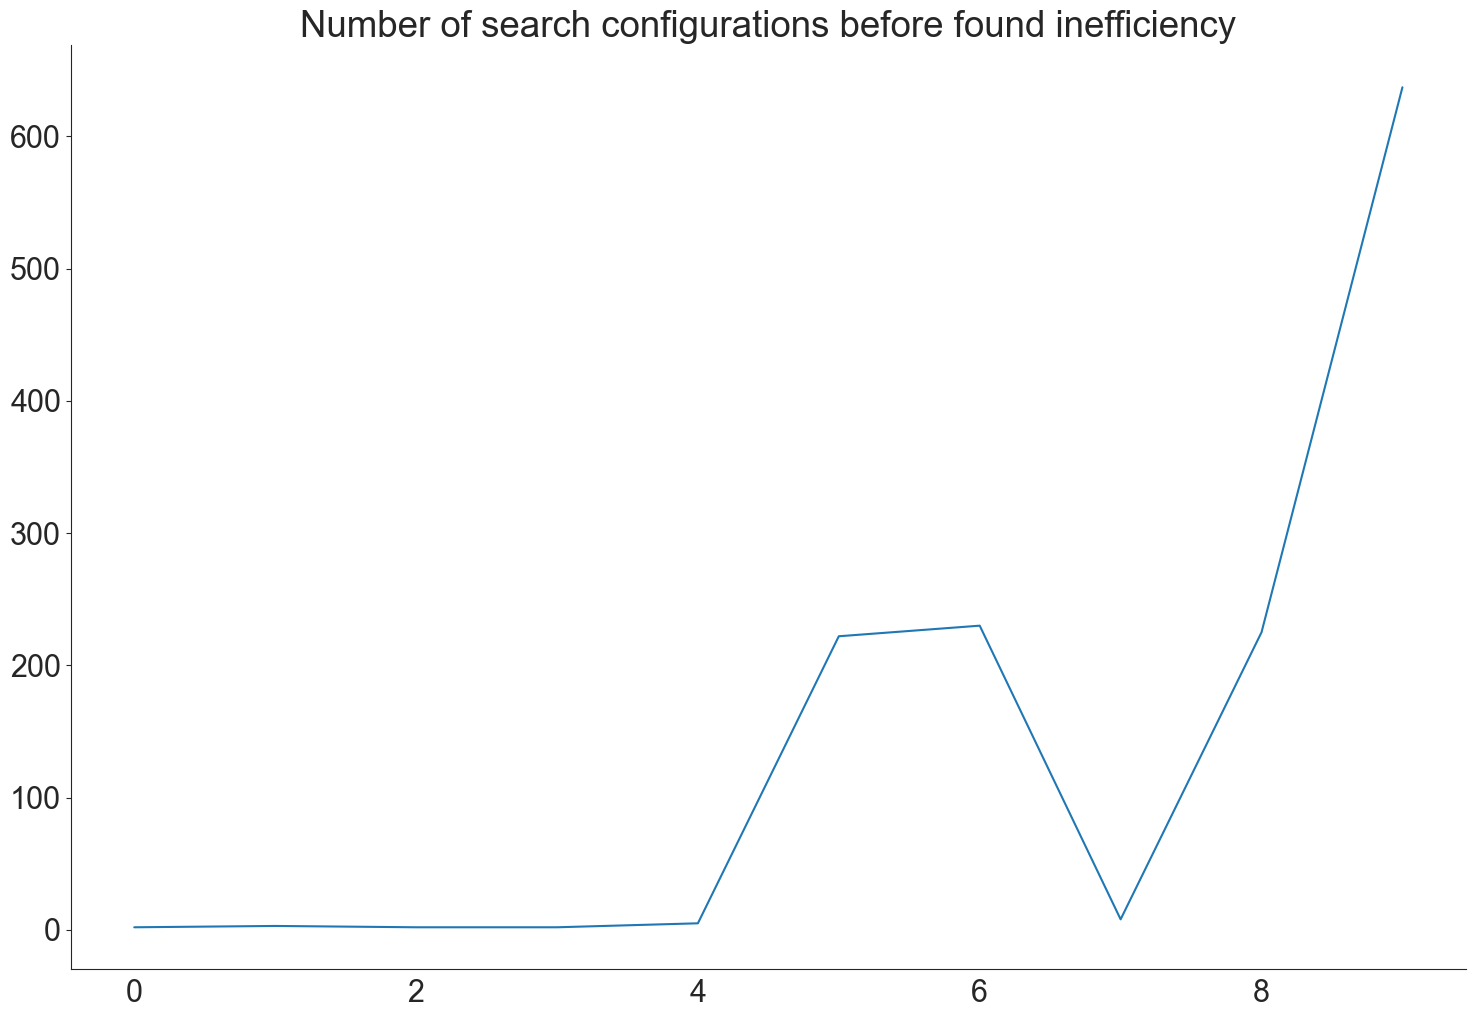

cost at iteration 0: 9.799999999999999, cost at iteration 10: 3.5


In [22]:
plt.figure(figsize=(18,12))
plt.plot(list(range(len(stats_tr))), stats_tr)
plt.title('Number of search configurations before found inefficiency')
plt.show()
print(f'cost at iteration 0: {cost_tr[0]}, cost at iteration {len(stats_tr)}: {cost_tr[-1]}')

## Before tabu search

In [23]:
print(f"Number of workers with over hours: {len(res_df_costs[res_df_costs['shift'] > 3])}")
print(f"Number of workers with ok hours: {len(res_df_costs[res_df_costs['shift'] == 3])}")
print(f"Number of workers with under hours: {len(res_df_costs[res_df_costs['shift'] < 3])}")

Number of workers with over hours: 14
Number of workers with ok hours: 40
Number of workers with under hours: 17


## After tabu search

In [24]:
data_shifts = pd.DataFrame(list(s_tr.values())).reset_index().groupby(0).count()[['index']]
print(f"Number of workers with over hours: {len(data_shifts[data_shifts['index'] > 3])}")
print(f"Number of workers with ok hours: {len(data_shifts[data_shifts['index'] == 3])}")
print(f"Number of workers with under hours: {len(data_shifts[data_shifts['index'] < 3])}")

Number of workers with over hours: 4
Number of workers with ok hours: 57
Number of workers with under hours: 10


### To conclude, graph coloring and tabu search showed decent performance in crew rostering task. 